In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import numpy as np
import os
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
#import json
import pandas as pd
import orjson as json
import re

from ue4nlp.ue_scores import *
from ue4nlp.ue_variation_ratio import ue_variation_ratio

from utils.plot_error_detection import draw_charts
from utils.plot_error_detection import create_chart_data

import matplotlib.pyplot as plt
from utils.plot_error_detection import plot_error_detection, plot_rejection_curve_aucs


def plot_roc_auc(res_path):
    with open(Path(res_path) / 'dev_inference.json') as f:
        model_outputs = json.loads(f.read())
    
    
    plot_error_detection(np.asarray(model_outputs['probabilities']), 
                         np.asarray(model_outputs['true_labels']), 
                         np.asarray(model_outputs['sampled_probabilities']).transpose(1, 0, 2))
    
def plot_rejection_curves(res_path):
    with open(Path(res_path) / 'dev_inference.json') as f:
        model_outputs = json.loads(f.read())
    
    plot_rejection_curve_aucs(np.asarray(model_outputs['probabilities']), 
                              np.asarray(model_outputs['true_labels']), 
                              np.asarray(model_outputs['sampled_probabilities']).transpose(1, 0, 2),
                              np.asarray(model_outputs['answers']), )

In [3]:
def calc_uncertainty_regection_curve(errors, uncertainty, group_by_uncertainty=True):
    n_objects = errors.shape[0]
    if group_by_uncertainty:
        data = pd.DataFrame(dict(
            errors=errors,
            uncertainty=uncertainty
        ))
        mean_errors = data.groupby("uncertainty").mean()
        mean_errors.rename(columns={"errors": "mean_errors"}, inplace=True)
        data = data.join(mean_errors, "uncertainty")
        data.drop("errors", axis=1, inplace=True)

        uncertainty_order = data["uncertainty"].argsort()
        errors = data["mean_errors"][uncertainty_order]
    else:
        uncertainty_order = uncertainty.argsort()
        errors = errors[uncertainty_order]

    error_rates = np.zeros(n_objects + 1)
    error_rates[:-1] = np.cumsum(errors)[::-1]# / n_objects
    return error_rates

def calc_aucs(errors, uncertainty):
    uncertainty_rejection_curve = calc_uncertainty_regection_curve(errors, uncertainty)
    uncertainty_rejection_auc = uncertainty_rejection_curve.mean()
    random_rejection_auc = uncertainty_rejection_curve[0] / 2
    ideal_rejection_auc = calc_uncertainty_regection_curve(errors, errors).mean()

    rejection_ratio = (uncertainty_rejection_auc - random_rejection_auc) / (
            ideal_rejection_auc - random_rejection_auc) * 100.0
    return rejection_ratio, uncertainty_rejection_auc

In [4]:
res_path = '../workdir/run_glue_for_model_series/electra_raw_sn/20newsgroups/0.0/nuq/results/42'

In [5]:
with open(Path(res_path) / 'dev_inference.json') as f:
    model_outputs = json.loads(f.read())

In [32]:
unc = np.asarray(model_outputs['epistemic'])

probs = np.asarray(model_outputs['probabilities'])
labels = np.asarray(model_outputs['true_labels'])

predictions = np.argmax(probs, axis=-1)
errors = (labels != predictions).astype("uint64")#.astype("uint8")

In [33]:
calc_aucs(errors, unc)

(67.64706822814665, 0.033721513815050216)

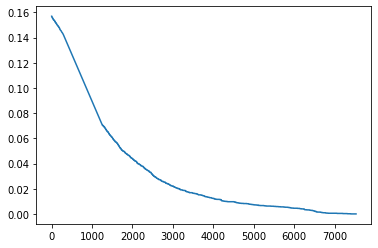

In [34]:
plt.plot(calc_uncertainty_regection_curve(errors, unc))

In [37]:
from analyze_results import *

res, x, y = rcc_auc(-unc, errors, return_points=True)

In [38]:
res

352.6944805428053

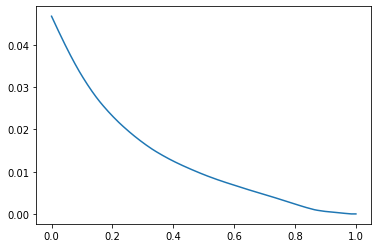

In [39]:
plt.plot(x, np.cumsum(y)[::-1]/len(y))

In [40]:
import pandas as pd
import numpy as np

from sklearn.metrics import *
from sklearn.utils.multiclass import type_of_target
from sklearn.utils import check_consistent_length, column_or_1d, assert_all_finite
from sklearn.utils.extmath import stable_cumsum


def calc_uncertainty_regection_curve(errors, uncertainty, group_by_uncertainty=True):
    n_objects = errors.shape[0]
    if group_by_uncertainty:
        data = pd.DataFrame(dict(
            errors=errors,
            uncertainty=uncertainty
        ))
        mean_errors = data.groupby("uncertainty").mean()
        mean_errors.rename(columns={"errors": "mean_errors"}, inplace=True)
        data = data.join(mean_errors, "uncertainty")
        data.drop("errors", axis=1, inplace=True)

        uncertainty_order = data["uncertainty"].argsort()
        errors = data["mean_errors"][uncertainty_order]
    else:
        uncertainty_order = uncertainty.argsort()
        errors = errors[uncertainty_order]

    error_rates = np.zeros(n_objects + 1)
    error_rates[:-1] = np.cumsum(errors)[::-1] / n_objects
    return error_rates


assert np.allclose(
    calc_uncertainty_regection_curve(np.array([2, 1]), np.array([1, 0])).mean(),
    2 / 3
)
assert np.allclose(
    calc_uncertainty_regection_curve(np.arange(5), np.array([0, 0, 2, 1, 1])).mean(),
    0.8
)
debug_errors = np.random.rand(10)
assert np.allclose(
    calc_uncertainty_regection_curve(debug_errors, np.zeros_like(debug_errors)).mean(),
    debug_errors.mean() / 2
)


def calc_aucs(errors, uncertainty):
    uncertainty_rejection_curve = calc_uncertainty_regection_curve(errors, uncertainty)
    uncertainty_rejection_auc = uncertainty_rejection_curve.mean()
    random_rejection_auc = uncertainty_rejection_curve[0] / 2
    ideal_rejection_auc = calc_uncertainty_regection_curve(errors, errors).mean()

    rejection_ratio = (uncertainty_rejection_auc - random_rejection_auc) / (
            ideal_rejection_auc - random_rejection_auc) * 100.0
    return rejection_ratio, uncertainty_rejection_auc


def prr_classification(labels, probs, measure, rev: bool):
    if rev:
        measure = -measure
    preds = np.argmax(probs, axis=1)
    errors = (labels != preds).astype("float32")
    return calc_aucs(errors, measure)


def prr_regression(targets, preds, measure):
    preds = np.squeeze(preds)
    # Compute MSE errors
    errors = (preds - targets) ** 2
    return calc_aucs(errors, measure)


def ood_detect(domain_labels, in_measure, out_measure, mode='ROC', pos_label=1):
    scores = np.concatenate((in_measure, out_measure), axis=0)
    scores = np.asarray(scores, dtype=np.float128)
    if pos_label != 1:
        scores *= -1.0

    if mode == 'PR':
        precision, recall, thresholds = precision_recall_curve(domain_labels, scores)
        aupr = auc(recall, precision)
        return aupr

    elif mode == 'ROC':
        roc_auc = roc_auc_score(domain_labels, scores)
        return roc_auc


def nll_regression(target, mu, var, epsilon=1e-8, raw=False):
    nll = (target - mu) ** 2 / (2.0 * var + epsilon) + np.log(var + epsilon) / 2.0 + np.log(2 * np.pi) / 2.0
    if raw:
        return nll
    return np.mean(nll)


def nll_class(target, probs, epsilon=1e-10):
    log_p = -np.log(probs + epsilon)
    return target * log_p[:, 1] + (1 - target) * log_p[:, 0]


def ens_nll_regression(target, preds, epsilon=1e-8, raw=False):
    mu = preds[:, :, 0]
    var = preds[:, :, 1]
    nll = (target - mu) ** 2 / (2.0 * var + epsilon) + np.log(var + epsilon) / 2.0 + np.log(2 * np.pi) / 2.0
    proba = np.exp(-1 * nll)
    if raw:
        return -1 * np.log(np.mean(proba, axis=0))
    return np.mean(-1 * np.log(np.mean(proba, axis=0)))


def calc_rmse(preds, target, raw=False):
    if raw:
        return (preds - target) ** 2
    return np.sqrt(np.mean((preds - target) ** 2))


def ens_rmse(target, preds, epsilon=1e-8, raw=False):
    means = preds[:, :, 0]  # mean values predicted by all models
    avg_mean = np.mean(means, axis=0)  # average predicted mean value
    if raw:
        return calc_rmse(avg_mean, target, raw=True)
    return calc_rmse(avg_mean, target)


def _check_pos_label_consistency(pos_label, y_true):
    # ensure binary classification if pos_label is not specified
    # classes.dtype.kind in ('O', 'U', 'S') is required to avoid
    # triggering a FutureWarning by calling np.array_equal(a, b)
    # when elements in the two arrays are not comparable.
    classes = np.unique(y_true)
    if (pos_label is None and (
            classes.dtype.kind in 'OUS' or
            not (np.array_equal(classes, [0, 1]) or
                 np.array_equal(classes, [-1, 1]) or
                 np.array_equal(classes, [0]) or
                 np.array_equal(classes, [-1]) or
                 np.array_equal(classes, [1])))):
        classes_repr = ", ".join(repr(c) for c in classes)
        raise ValueError(
            f"y_true takes value in {{{classes_repr}}} and pos_label is not "
            f"specified: either make y_true take value in {{0, 1}} or "
            f"{{-1, 1}} or pass pos_label explicitly."
        )
    elif pos_label is None:
        pos_label = 1.0

    return pos_label


def _binary_clf_curve_ret(y_true, y_score, pos_label=None, sample_weight=None):
    # Check to make sure y_true is valid
    y_type = type_of_target(y_true)
    if not (y_type == "binary" or
            (y_type == "multiclass" and pos_label is not None)):
        raise ValueError("{0} format is not supported".format(y_type))

    check_consistent_length(y_true, y_score, sample_weight)
    y_true = column_or_1d(y_true)
    y_score = column_or_1d(y_score)
    assert_all_finite(y_true)
    assert_all_finite(y_score)

    if sample_weight is not None:
        sample_weight = column_or_1d(sample_weight)

    pos_label = _check_pos_label_consistency(pos_label, y_true)

    # make y_true a boolean vector
    y_true = (y_true == pos_label)

    # sort scores and corresponding truth values
    desc_score_indices = np.argsort(y_score, kind="mergesort")[::-1]
    y_score = y_score[desc_score_indices]
    y_true = y_true[desc_score_indices]
    if sample_weight is not None:
        weight = sample_weight[desc_score_indices]
    else:
        weight = 1.

    # y_score typically has many tied values. Here we extract
    # the indices associated with the distinct values. We also
    # concatenate a value for the end of the curve.
    # distinct_value_indices = np.where(np.diff(y_score))[0]
    # threshold_idxs = np.r_[distinct_value_indices, y_true.size - 1]

    # accumulate the true positives with decreasing threshold
    tps = stable_cumsum(y_true * weight)  # [threshold_idxs]
    if sample_weight is not None:
        # express fps as a cumsum to ensure fps is increasing even in
        # the presence of floating point errors
        fps = stable_cumsum((1 - y_true) * weight)  # [threshold_idxs]
    else:
        fps = stable_cumsum((1 - y_true))  # [threshold_idxs]
    return fps, tps, y_score  # [threshold_idxs]


def _precision_recall_curve_retention(y_true, probas_pred, *, pos_label=None,
                                      sample_weight=None):
    fps, tps, thresholds = _binary_clf_curve_ret(y_true, probas_pred,
                                                 pos_label=pos_label,
                                                 sample_weight=sample_weight)

    precision = tps / (tps + fps)
    precision[np.isnan(precision)] = 0
    recall = tps / tps[-1]

    # stop when full recall attained
    # and reverse the outputs so recall is decreasing
    last_ind = tps.searchsorted(tps[-1])
    sl = slice(-1, None, -1)
    return np.r_[precision[sl], 1], np.r_[recall[sl], 0], thresholds[sl]


def _acceptable_error(errors, threshold):
    return np.asarray(errors <= threshold, dtype=np.float32)


def _calc_fbeta_regection_curve(errors, uncertainty, threshold, beta=1.0, group_by_uncertainty=True, eps=1e-10):
    ae = _acceptable_error(errors, threshold)
    pr, rec, _ = _precision_recall_curve_retention(ae, -uncertainty)
    pr = np.asarray(pr)
    rec = np.asarray(rec)
    f_scores = (1 + beta ** 2) * pr * rec / (pr * beta ** 2 + rec + eps)

    return f_scores, pr, rec


def f_beta_metrics(errors, uncertainty, threshold, beta=1.0):
    """
    :param errors: Per sample errors - array [n_samples]
    :param uncertainty: Uncertainties associated with each prediction. rray [n_samples]
    :param threshold: The error threshold below which we consider the prediction acceptable
    :param beta: The beta value for the F_beta metric. Defaults to 1
    :return: fbeta_auc, fbeta_95, retention
    """
    f_scores, pr, rec = _calc_fbeta_regection_curve(errors, uncertainty, threshold, beta)
    ret = np.arange(pr.shape[0]) / pr.shape[0]

    f_auc = auc(ret[::-1], f_scores)
    f95 = f_scores[::-1][np.int(0.95 * pr.shape[0])]

    return f_auc, f95, f_scores[::-1]

In [41]:
f_auc, f95, f_scores = f_beta_metrics(errors, unc, 0.5)

/opt/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:241: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [42]:
f_auc

0.6395928981260036

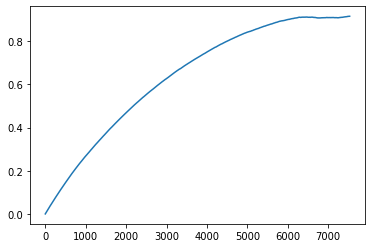

In [43]:
plt.plot(f_scores)

In [44]:
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, auc, roc_auc_score, f1_score

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import json
import re

from ue4nlp.ue_scores import *

def get_score_ratio(sorted_indexes, answers, true_answers, ratio):
    last_index = int(len(sorted_indexes) * ratio)
    sel_indexes = sorted_indexes[:last_index]
    unsel_indexes = sorted_indexes[last_index:]

    sel_answers = true_answers[sel_indexes].tolist() + answers[unsel_indexes].tolist()
    sel_true_answers = (
        true_answers[sel_indexes].tolist() + true_answers[unsel_indexes].tolist()
    )
    #score = accuracy_score(sel_true_answers, sel_answers)
    score = f1_score(sel_true_answers, sel_answers, average='micro')
    return score


predictions = np.argmax(probs, axis=-1)
errors = (labels != predictions).astype("uint8")
ratio_list = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

ue_scores = unc
ensemble_answers = np.asarray(probs).argmax(-1)
sorted_indexes_ensemble = np.argsort(-ue_scores)
ens_scores = [
    get_score_ratio(sorted_indexes_ensemble, ensemble_answers, labels, ratio)
    for ratio in ratio_list
]

print(f"mahalanobis:", auc(ratio_list, ens_scores))

mahalanobis: 0.9230582846521508


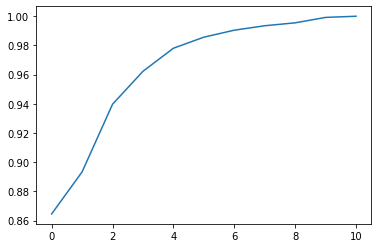

In [45]:
plt.plot(ens_scores)

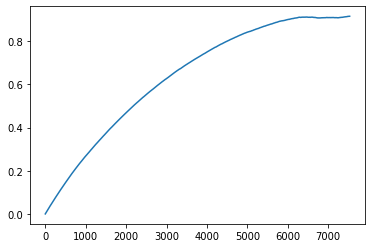

In [46]:
plt.plot(f_scores)